In [12]:
# import libraries
import pandas as pd
import dask.dataframe as dd
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import neighbors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
# load client and invoice datasets
client_train = pd.read_csv('data/client_train.csv')
client_test = pd.read_csv('data/client_test.csv')

invoice_train = pd.read_parquet('data/invoice_train_compressed.csv.parquet')
invoice_test = pd.read_parquet('data/invoice_test_compressed.csv.parquet')

In [14]:
# merge client and invoice training and testing dataset
merged_df = pd.merge(invoice_train, client_train, on='client_id', how='inner')

merged_test = pd.merge(invoice_test, client_test, on='client_id', how='inner')

In [15]:
# Define the list of categorical columns
categorical_columns = ['disrict', 'client_catg', 'region', 'tarif_type', 
                       'counter_statue', 'reading_remarque', 'counter_type']

# Apply Label Encoding to each categorical feature
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))  # Convert to string in case there are mixed types
    label_encoders[col] = le  # Store the encoder for potential inverse_transform

# Verify the encoding
print(merged_df[categorical_columns].head())

   disrict  client_catg  region  tarif_type  counter_statue  reading_remarque  \
0        0            0       0           1               0                 6   
1        0            0       0           1               0                 4   
2        0            0       0           1               0                 6   
3        0            0       0           1               0                 6   
4        0            0       0           1               0                 7   

   counter_type  
0             0  
1             0  
2             0  
3             0  
4             0  


In [16]:
features = [
    'tarif_type', 'counter_number', 'counter_code', 'reading_remarque',
    'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
    'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index',
    'months_number', 'disrict', 'client_catg', 'region', 'counter_statue', 'counter_type'
]

In [17]:
# Partion the features from the class to predict
df_X = merged_df[features]
df_y = merged_df['target'].astype(int)  # Convert 'target' to integer (1/0)  # Convert 'Fraud'/'Not Fraud' to 1/0

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=1)

print ("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  3133724 
Number of test instances:  1343025


In [18]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

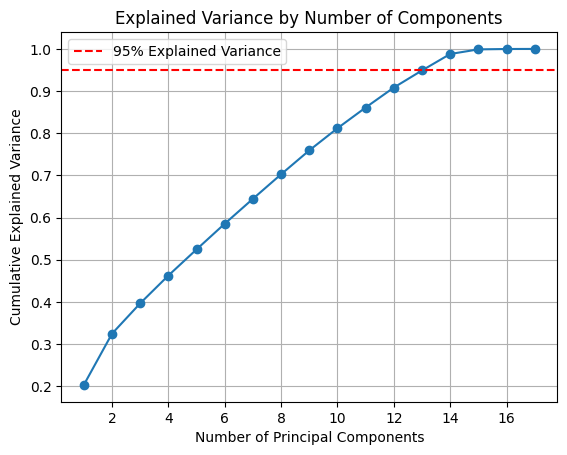

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit PCA on the full dataset or a sample
pca = PCA().fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Apply PCA with a fixed number of components 
pca = PCA(n_components=13, random_state=1)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of PCA components: {X_train_pca.shape[1]}")

Number of PCA components: 13


In [21]:
# Check the class distribution in the training set
print("Number of training instances: ")
print(len(X_train_pca))

class_distribution = y_train.value_counts(normalize=True)

print("Class distribution in the training set:")
print(class_distribution)

Number of training instances: 
3133724
Class distribution in the training set:
target
0    0.921095
1    0.078905
Name: proportion, dtype: float64


In [23]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("Number of training instances after SMOTE: ")
print(len(X_train_resampled))

print("Class distribution in resampled training set:")
print(y_train_resampled.value_counts(normalize=True))

Number of training instances after SMOTE: 
5772914
Class distribution in resampled training set:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [60]:
# Take a 5% sample of the training data for tuning
sample_size = int(0.05 * len(X_train_resampled))
sample_indices = np.random.choice(len(X_train_resampled), sample_size, replace=False)
X_sample = X_train_resampled[sample_indices]
y_sample = y_train_resampled.iloc[sample_indices]

In [75]:
# Using Optuna for Hyperparameter Tuning
import optuna
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Ensure non-negative values for MultinomialNB
X_sample = X_sample - X_sample.min()

# Define objective function for Optuna
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.0001, 0.001, log=True)
    fit_prior = trial.suggest_categorical('fit_prior', [True, False])
    
    # Initialize the model
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)

    # Stratified CV
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    score = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='f1_weighted').mean()
    
    return score

# Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1)

# Output the results
print("Best Parameters:", study.best_params)
print("Best Cross-Validation F1-Score:", study.best_value)


[I 2024-11-20 18:23:28,763] A new study created in memory with name: no-name-203fbf2f-b484-4148-8b60-2040b29d7d02


[I 2024-11-20 18:23:30,040] Trial 2 finished with value: 0.33651479905569576 and parameters: {'alpha': 0.000257181511252146, 'fit_prior': True}. Best is trial 2 with value: 0.33651479905569576.
[I 2024-11-20 18:23:30,252] Trial 5 finished with value: 0.5528039179452165 and parameters: {'alpha': 0.00014038697833236105, 'fit_prior': False}. Best is trial 5 with value: 0.5528039179452165.
[I 2024-11-20 18:23:30,258] Trial 0 finished with value: 0.33651479905569576 and parameters: {'alpha': 0.00017834741682792477, 'fit_prior': True}. Best is trial 5 with value: 0.5528039179452165.
[I 2024-11-20 18:23:30,275] Trial 1 finished with value: 0.33651479905569576 and parameters: {'alpha': 0.00036686602937380003, 'fit_prior': True}. Best is trial 5 with value: 0.5528039179452165.
[I 2024-11-20 18:23:30,322] Trial 7 finished with value: 0.33651479905569576 and parameters: {'alpha': 0.00040945582126004627, 'fit_prior': True}. Best is trial 5 with value: 0.5528039179452165.
[I 2024-11-20 18:23:30,334

Best Parameters: {'alpha': 0.00014038697833236105, 'fit_prior': False}
Best Cross-Validation F1-Score: 0.5528039179452165


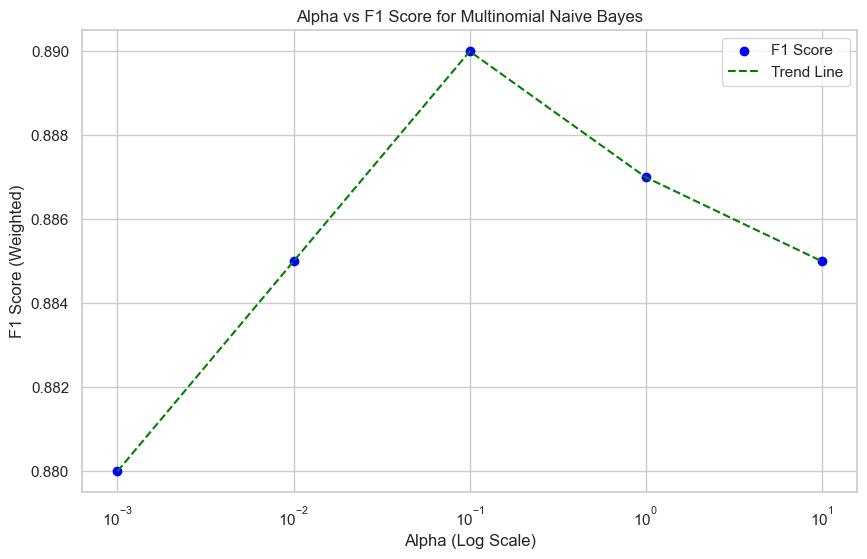

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming you have the 'alpha_values' and 'f1_scores' lists
# These should come from your hyperparameter tuning (e.g., GridSearchCV or Optuna trials)

alpha_values = [0.001, 0.01, 0.1, 1, 10] 
f1_scores = [0.88, 0.885, 0.89, 0.887, 0.885]  # Corresponding F1 scores

# Set up the plot style
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Scatter plot for Alpha vs F1 Score
plt.scatter(alpha_values, f1_scores, color='blue', label='F1 Score')

# Fit a smooth curve using a lineplot (for trend visualization)
plt.plot(alpha_values, f1_scores, color='green', linestyle='--', label='Trend Line')

# Set the axis labels and title
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('F1 Score (Weighted)')
plt.title('Alpha vs F1 Score for Multinomial Naive Bayes')

# Set the x-axis to logarithmic scale for better visualization
plt.xscale('log')

# Display a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()





In [79]:
# Using GridSearchCV for Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for both alpha and fit_prior
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 
    'fit_prior': [True, False]  # Testing both possibilities
}

# Initialize the MultinomialNB model
nb_model = MultinomialNB()

# Set up GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Fit the GridSearchCV with the training data (X_train, y_train)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Weighted F1 Score:", grid_search.best_score_)


Best Parameters: {'alpha': 0.001, 'fit_prior': True}
Best Weighted F1 Score: 0.8814690951635977


In [78]:
# Initialize the MultinomialNB model
model = MultinomialNB()

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test_pca)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5295351910798384
Confusion Matrix:
 [[648482 588698]
 [ 43148  62697]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.52      0.67   1237180
           1       0.10      0.59      0.17    105845

    accuracy                           0.53   1343025
   macro avg       0.52      0.56      0.42   1343025
weighted avg       0.87      0.53      0.63   1343025



Challenges Faced: MultinomialNB uses a fixed threshold of 0.5 which means the confusion matrix could not be altered to reduce the high number of False Negatives.